## Executive Summary 

This paper presents improvements on binary classification between natural and built environments, advancing prior work by integrating enhanced feature analysis and sophisticated modeling techniques. We extend our investigation beyond the simple classification tasks explored in previous assignments to delve into understanding what fundamentally differentiates these images.

Our methodology encompasses a robust workflow that begins with data ingestion and initial feature analysis using tools like LIME (Local Interpretable Model-agnostic Explanations) and YOLO (You Only Look Once). We significantly expand our dataset by incorporating a more extensive collection from publicly available sources, allowing for a broader analysis and reducing overfitting. This enriched dataset undergoes various pre-processing steps such as data splitting and augmentation before being subjected to model training using advanced neural networks including ResNet50 and Vision Transformers.

A significant portion of our analysis is dedicated to exploring "black-box" features through techniques such as LIME, to identify and understand the contributions of specific image features to classification decisions. This paper demonstrates that ResNet50, a pretrained CNN, significantly outperforms other models in terms of accuracy and efficiency on our dataset.

Key modifications from previous works include shifting the focus from mere classification to identifying distinguishing features, incorporating larger datasets to enhance model robustness, and evaluating advanced models like Vision Transformers. These shifts in focus are meticulously documented and analyzed, showing clear, empirical evidence of performance improvements.

Conclusively, our findings advocate for the continued use of sophisticated CNN architectures for complex classification tasks and suggest potential areas for further research, such as the exploration of Capsule Networks to address spatial hierarchies between features that conventional CNNs might overlook.

## Workflow
1. Data Ingestion
2. Initial Feature Analysis with LIME and YOLO 
3. Data Splitting 
4. Data Augmentation 
5. Various Model Training 
6. Model Evaluation and Comparison 
7. Conclusions 
8. Proposed changes

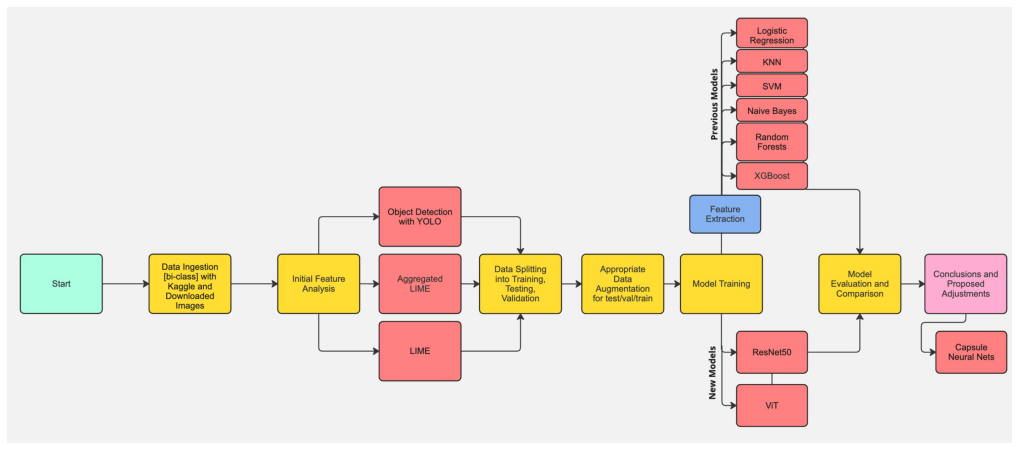

In [79]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the image
img = Image.open("/Users/etoileboots/Downloads/flowchartforp3.jpg")

# Create a figure with specific size
fig = plt.figure(figsize=(18, 18)) 

# Display the image
plt.imshow(img)

# Remove axes and show the figure
plt.axis('off')
plt.show()


## *Note on Pertinant Changes from Previous Assignments*
In the previous two assignments, our primary focus was on being able to perform a relatively accurate binary classification between natural and built environments. This led us to explore a variety of models, including logistic regression, SVM, KNN, Gaussian NB, RF, and XGBoost. From this exploration of various models, we found that logistic regression, while one of the simplest of models, had performed to best.

In this final assignment, there are a few key modifications:

1. Shift in core question from simple "*can we classify these images?*" to, "*what makes these images different?*"

2. Incorporation of more data, to reduce the likelihood of overfitting and increase the predictive accuracy of this model

3. Inclusion of advanced models to improve the predictive accuracy of the model.

These core attentional shifts of this project have led to a few tangible differences that you will observe throughout this reading. Note that the previously trained models are still included, however, their descriptions have been omitted, as the main focus of this assignment is on the newly included content.

# Integration with Larger Data

In the previous assignments, there was a sample size of around 300 for each category, urban and rural. This sample was increased artificially through various data augmentation methods. For this assignment, however, my personal dataset has been supplemented with publicly available data from both categories. More specifically, urban image data and natural image data has been introduced from Kaggle.

The reason for using a larger data sample was that some of the more complicated models that we will be working with in this project are better suited for large data. This includes Visual Transformers and various CNNs which are more prone to overfitting, given the large number of parameters arising from it's layered structure.

We begin by integrating a largely "natural" image dataset, taken from Kaggle's Intel Image Classification (Bental, 2020). This includes ~25k images under 6 categories, 4 of which is representing a natural area, and 2 of which is urban. These exact categories have been listed below.

*Natural Areas:*
1. Forest
2. Sea
3. Mountain
4. Glacier

*Urban Areas:*
1. Buildings
2. Streets

Note that we will be limiting the total dataset size to 1000 images, to ensure that the model can train on my laptop, as with earlier iterations of this assignment where ~8000 images were used, but the runtime would disconnect before training was completed.

In [1]:
!pip install opendatasets --upgrade --quiet

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
# DOWNLOAD ONE SET OF IMAGE FILES - URBAN DATA HEAVY

# Import libraries
import opendatasets as od

# Assign the Kaggle data set URL into variable
dataset = 'https://www.kaggle.com/puneet6060/intel-image-classification'

# Using opendatasets, download the data sets
od.download(dataset)

Skipping, found downloaded files in "./intel-image-classification" (use force=True to force download)


In [4]:
import os

# Path to the Kaggle dataset
kaggle_data_path = '/Users/etoileboots/intel-image-classification/seg_train'

# Check if the path exists
if not os.path.exists(kaggle_data_path):
    print(f"Kaggle data path does not exist: {kaggle_data_path}")
else:
    print(f"Kaggle data path exists: {kaggle_data_path}")
    # List categories
    categories = os.listdir(kaggle_data_path)
    print("Found categories:", categories)

    # List a few files from each category
    for category in categories:
        category_path = os.path.join(kaggle_data_path, category)
        if os.path.isdir(category_path):
            print(f"\nFiles in {category}:")
            files = os.listdir(category_path)[:5]  # List the first 5 files
            for file in files:
                print(file)
        else:
            print(f"Expected directory for category, found file: {category}")


Kaggle data path exists: /Users/etoileboots/intel-image-classification/seg_train
Found categories: ['.DS_Store', 'seg_train']
Expected directory for category, found file: .DS_Store

Files in seg_train:
forest
buildings
.DS_Store
glacier
street


In [5]:
import os
import shutil
import random

# Categorization mapping for urban and natural categories from the Kaggle dataset
urban_categories = ['buildings', 'street']  # Example urban categories in Kaggle dataset
natural_categories = ['forest', 'sea', 'mountain', 'glacier']  # Example natural categories in Kaggle dataset

# Personal dataset paths
urban_data_path_personal = '/Users/etoileboots/Downloads/PIPELINE2_DATA/built'
natural_data_path_personal = '/Users/etoileboots/Downloads/PIPELINE2_DATA/natural'

# Kaggle dataset paths
kaggle_data_path = '/Users/etoileboots/intel-image-classification/seg_train/seg_train'

# Target directories
data_dir = '/Users/etoileboots/Downloads/dataset/'
urban_dir = os.path.join(data_dir, 'urban')
natural_dir = os.path.join(data_dir, 'natural')

# Ensure directories exist
os.makedirs(urban_dir, exist_ok=True)
os.makedirs(natural_dir, exist_ok=True)

def move_images(source_directory, target_directory, max_images=1000):
    """
    Copies a limited number of image files from the source directory to the target directory.
    This function ensures that only up to 'max_images' are in the target directory after operation.
    """
    existing_files = os.listdir(target_directory)
    if len(existing_files) >= max_images:
        return  # Already have enough images

    # Calculate how many more files are needed
    needed = max_images - len(existing_files)
    files = [f for f in os.listdir(source_directory) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

    # Ensure we don't try to move more files than we need
    if len(files) > needed:
        files = random.sample(files, needed)

    for item in files:
        source_path = os.path.join(source_directory, item)
        target_path = os.path.join(target_directory, item)
        shutil.copy(source_path, target_path)  # Use copy to retain original files

def categorize_and_move_files(categories, source_base_path, target_dir):
    for category in categories:
        source_path = os.path.join(source_base_path, category)
        if os.path.exists(source_path):
            move_images(source_path, target_dir, 1000)  # Ensure each category has up to 1000 images

# Move urban and natural categorized files from Kaggle dataset
categorize_and_move_files(urban_categories, kaggle_data_path, urban_dir)
categorize_and_move_files(natural_categories, kaggle_data_path, natural_dir)

# Add personal urban and natural images, if needed
move_images(urban_data_path_personal, urban_dir, 1000)
move_images(natural_data_path_personal, natural_dir, 1000)

print(f"Total urban images: {len(os.listdir(urban_dir))}")
print(f"Total natural images: {len(os.listdir(natural_dir))}")


Total urban images: 1000
Total natural images: 1000


The datasets now contain 1000 photos each and are exactly equal, fantastic! Let's now visualize these images, just to get a sense of the data we are working with.

## Display Images

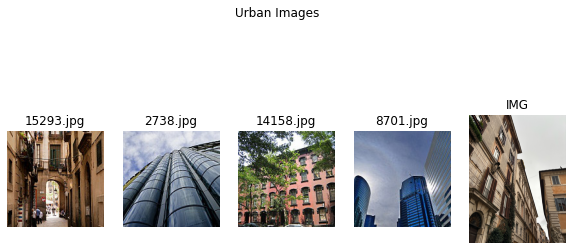

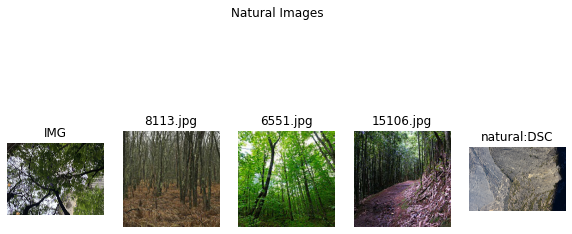

In [6]:
# Import the necessary libraries.
import matplotlib.pyplot as plt
from PIL import Image
import random

# Function to display images from a specified directory
def display_images_from_directory(directory, title):
    plt.figure(figsize=(10, 5))
    plt.suptitle(title)
    files = random.sample(os.listdir(directory), 5)  # Randomly pick 5 images to display
    for i, file in enumerate(files):
        img_path = os.path.join(directory, file)
        img = Image.open(img_path)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.title(file.split('_')[0])  # Optionally, use the filename to show category
        plt.axis('off')
    plt.show()

# Display sample images from 'urban' and 'natural' directories
display_images_from_directory(urban_dir, "Urban Images")
display_images_from_directory(natural_dir, "Natural Images")


# "Black-Box" Feature Exploration with LIME and YOLO

In the previous assignment, there was a brief analysis of features through feature extraction via a pretrained CNN and PCA analysis. In this paper, we extend upon previous efforts to focus in on the various features that are leading the eventual classification of the images. In order to do so, we will first use local interpretable model-agnostic explanations (LIME).

#### **LIME**
##### **General Overview**

LIME is an algorithm designed to allow us to understand the predictions that are made by ML models, as used previously. Oftentimes, the only output of a given model is it's predictive accuracy, or F1-score, but not the specific features, pixels, etc that led to its decision making. In the context of image classification, LIME identifies which features in the image (e.g., "superpixels") most influence the classification decision. This is done by perturbing the image — turning on and off different superpixels — and observing the effect on the model's output (Molnar, 2023).

This is important at this stage to perform such feature analysis, to better understand, via interpretable approximation, how black box models such complex deep learning models like CNNs and Vision Transformers with relatively uninterpretible decisions, go about the decision making process.

Before even analyzing the resulting superpixels, however, it is necessary to mention the constraint of such an approach. LIME does not highlight the model's global behavior (Ribeiro et al., 2016),  but works in the space of specific instances.

##### **Mechanics & Methodologies**

1. **Model**: The model used in this analysis is ResNet50, a convolutional neural network that is 50 layers deep. It is pre-trained on the ImageNet dataset, which includes a diverse range of images classified into numerous categories. The choice of ResNet50 is due to its robustness and proven accuracy in image classification tasks.
   
2. **Device Setup**: The analysis is conducted on a device with CUDA capability to leverage GPU acceleration, ensuring efficient computation.

3. **Image Processing**:
   - Each image is resized to 224x224 pixels to match the input size required by ResNet50.
   - Images are converted to tensors and normalized using the mean and standard deviation of the ImageNet dataset to maintain consistency with the training conditions of the model.

4. **Superpixelization**:
   - For each image, LIME computes the influence of each superpixel on the model’s output, highlighting the most impactful regions in determining the class of the image.


In [ ]:
!pip install lime

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

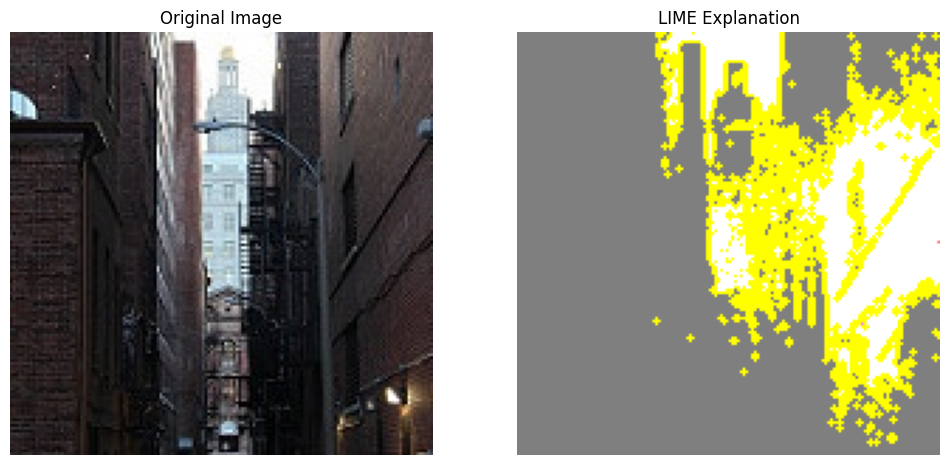

  0%|          | 0/1000 [00:00<?, ?it/s]

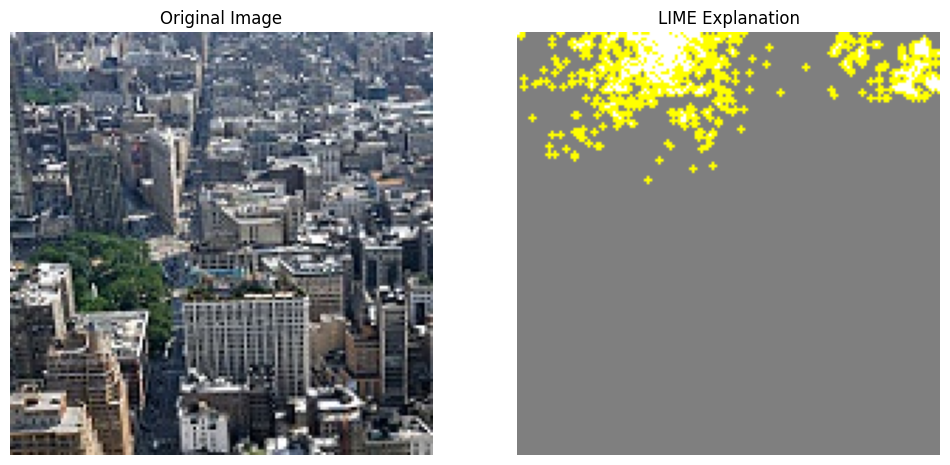

  0%|          | 0/1000 [00:00<?, ?it/s]

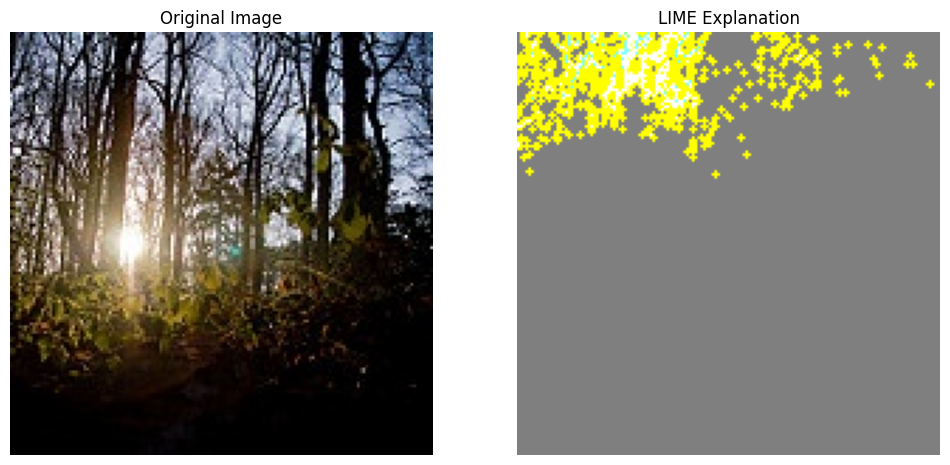

  0%|          | 0/1000 [00:00<?, ?it/s]

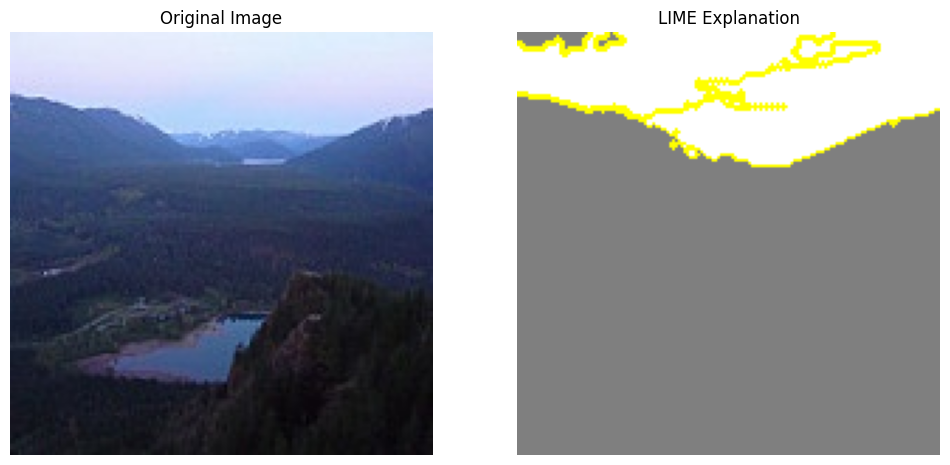

In [26]:
# import libraries
import numpy as np
from PIL import Image
import torch
from torchvision import models, transforms
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import os
import random

def get_device():
    """ Returns the available device, either GPU or CPU."""
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_image(path, device):
    """Load an image from disk, apply model transformations, and return both the tensor and original image."""
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
        transforms.ToTensor(),  # Convert the image to a PyTorch tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
    ])
    image = Image.open(path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return image_tensor.to(device), np.array(image)

def batch_predict(images):
    """Function to predict a batch of images and return probabilities."""
    model.eval()
    with torch.no_grad():
        outputs = model(images)
    return torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()

def explain(image_path, model, device, num_samples=1000, num_features=5, hide_rest=True):
    """Generate and visualize LIME explanation for a single image."""
    image_tensor, original_image = get_image(image_path, device)
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(original_image.astype('double'),  # ensure dtype is correct for LIME
                                             lambda x: batch_predict(torch.tensor(x.astype('float32')).permute(0, 3, 1, 2).to(device)),
                                             top_labels=5, hide_color=0 if hide_rest else None, num_samples=num_samples)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=num_features, hide_rest=hide_rest)

    # Create a subplot with 1 row and 2 columns
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    # Display the original image
    ax[0].imshow(original_image)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # Display the image with LIME explanation
    ax[1].imshow(mark_boundaries(temp / 2 + 0.5, mask))
    ax[1].set_title('LIME Explanation')
    ax[1].axis('off')

    plt.show()

# Setup the device and load the pre-trained model
device = get_device()
model = models.resnet50().to(device)

def choose_and_explain_random_images(directory, num_images=2):
    """Choose and explain random images from a directory."""
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg'))]
    selected_files = random.sample(files, min(len(files), num_images))  # Choose 2 or fewer images based on available number

    for image_path in selected_files:
        explain(image_path, model, device)

# Randomly choose and explain images from both directories
choose_and_explain_random_images(urban_dir)
choose_and_explain_random_images(natural_dir)


## Findings from LIME & Aggregated Lime

From LIME, we can observe the most influential pixel regions in determining the classification of specific images. For the urban images, there seems to be an emphasis on the building outlines, while for natural,the open space (sky) is highlighted.

We can do better, however. In order to better understand common, semi-global patterns and features, we can take the aggregated LIME, which analyzes multiple images, compute importance scores, and averages across all images to determine common patterns or features that consistently influence the model's decisions.

In [ ]:
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image
from lime import lime_image
from skimage.segmentation import mark_boundaries, quickshift
from skimage.transform import resize
import matplotlib.pyplot as plt
import os
import random

def get_device():
    """ Returns the available device, either GPU or CPU. """
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_and_transform_image(path):
    """Load an image from disk and apply transformations for model compatibility."""
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(path).convert('RGB')
    return transform(image)

def prepare_batch(image_paths):
    """Prepare a batch of images for model processing."""
    images = [load_and_transform_image(path) for path in image_paths]
    return torch.stack(images).to(device)

def batch_predict(images):
    """Make predictions on a batch of images using a pre-trained model."""
    model.eval()
    with torch.no_grad():
        outputs = model(images)
    return torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()

def modify_segmentation_fn(image):
    """Convert image to double precision before segmentation."""
    return quickshift(image.astype(np.double), kernel_size=4, max_dist=200, ratio=0.2)

def aggregate_lime_explanations(image_paths, model, device, num_samples=1000, num_features=5):
    """Aggregate LIME explanations for a set of images."""
    feature_importance = np.zeros((224, 224))
    explainer = lime_image.LimeImageExplainer()

    images = prepare_batch(image_paths)
    explanations = [
        explainer.explain_instance(
            image.permute(1, 2, 0).cpu().numpy(), # Ensure image is in [H, W, C] format
            classifier_fn=lambda x: batch_predict(torch.from_numpy(x.astype(np.float32)).permute(0, 3, 1, 2).to(device)),
            top_labels=1, hide_color=0, num_samples=num_samples,
            segmentation_fn=modify_segmentation_fn
        ) for image in images
    ]

    for explanation in explanations:
        _, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=num_features, hide_rest=True)
        feature_importance += resize(mask, (224, 224), mode='constant', anti_aliasing=False)

    feature_importance /= len(image_paths)
    plt.imshow(feature_importance, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title('Aggregated Feature Importance')
    plt.show()

# Setup the device and load the pre-trained model
device = get_device()
model = models.resnet50(pretrained=True).to(device)

def choose_images_for_analysis(directory, num_images=20):
    """Randomly select a fixed number of images from a directory for analysis."""
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg'))]
    return random.sample(files, min(len(files), num_images))
 
# Analyze 
urban_images = choose_images_for_analysis(urban_dir, 50)
aggregate_lime_explanations(urban_images, model, device)


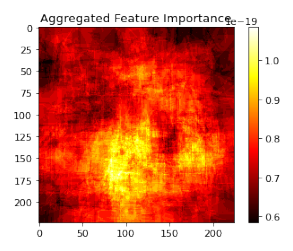

In [94]:
# Since the output of the previous code cell was too long, the final graph has re-uploaded here. 
# Load the image
img_urb_features = Image.open("/Users/etoileboots/Downloads/urban_features.png")

fig = plt.figure(figsize=(5,5))  

# Display the image
plt.imshow(img_urb_features)

# Remove axes and show the figure
plt.axis('off')
plt.show()


In [ ]:
natural_images = choose_images_for_analysis(natural_dir, 50)
aggregate_lime_explanations(natural_images, model, device)

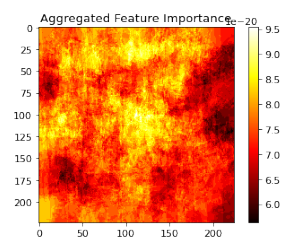

In [93]:
# Since the output of the previous code cell was too long, the final graph has re-uploaded here. 
img_nat_features = Image.open("/Users/etoileboots/Downloads/natural_features.png")

fig = plt.figure(figsize=(5, 5))

# Display the image
plt.imshow(img_nat_features)

# Remove axes and show the figure
plt.axis('off')
plt.show()


From this aggregated ferature performance, we can notice a few distinguishing patterns. The concentrated aggregated features of the natural images (for a sample of 50) seem to be more focused on the upper-half of the image, while for urban images, the superpixels are in the bottom center. This makes sense when we consider what images we see in the different categories. In urban images, it may be more likely to observe a street in the center of the image, or a building, which is the most important in categorizing the image. Meanwhile, natural images lend themselves more for distinguishable skies. Regardless, we can see that there is clearly a different feature importance for the different classes. 

# YOLO

In addition to analyzing the superpixels of these images, let's take a look at the visible differences that set urban and natural environments apart. This analysis is mostly relevant for individuals who wish to know the differences in object composition of the different environments. We will be using YOLO (You Only Look Once) for performing feature analysis in these different datasets.

YOLO is an object detection system which can identify and localize various objects within an image. This capability can be leveraged to discern and quantify distinct features and objects that distinguish one dataset from another, such as differentiating between urban and natural scenes in image datasets.

*Mechanism of YOLO*

YOLO utilizes a single neural network to predict bounding boxes and class probabilities directly from full images in one evaluation. This method contrasts sharply with other detection systems that require separate proposals to be generated before the actual object detection. By treating detection as a simple regression problem, YOLO divides the image into a grid and predicts bounding boxes and probabilities for each grid cell.

#### **Application in Feature Analysis**

When applied to feature analysis across datasets, YOLO can identify prevalent objects within each dataset, providing insights into the characteristics that are typical for each category. For example:

- **Urban Datasets**: YOLO might detect cars, buildings, roads, and pedestrians frequently, reflecting the human-made structures and high-density living conditions typical of urban environments.
- **Natural Datasets**: In contrast, it might frequently identify trees, water bodies, animals, and other natural elements, highlighting the organic and less structured features of natural landscapes.


In [11]:
!git clone https://github.com/ultralytics/yolov5  # Clone repo
!cd yolov5


Cloning into 'yolov5'...
remote: Enumerating objects: 16562, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 16562 (delta 20), reused 29 (delta 13), pack-reused 16522
Receiving objects: 100% (16562/16562), 15.08 MiB | 16.66 MiB/s, done.
Resolving deltas: 100% (11377/11377), done.


In [ ]:
import torch

# Load the YOLOv5 model using torch.hub
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

# Set model to evaluation mode
model.eval()


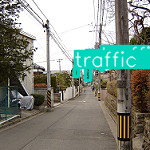

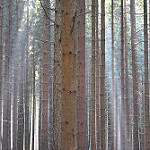

tensor([[ 74.10786,  68.75850,  78.76697,  76.85789,   0.52407,   9.00000],
        [100.52522,  63.67226, 103.92879,  70.07945,   0.44001,   9.00000],
        [ 85.16695,  67.85669,  90.46981,  80.92043,   0.29314,   9.00000]]) tensor([], size=(0, 6))


In [22]:
from PIL import Image
import numpy as np
import os

def detect_objects(image_path, model, show_results=False):
    try:
        # Ensure the image_path is a string and not a list
        if isinstance(image_path, list):
            image_path = image_path[0]  # Assuming the list contains one path

        # Check if the file exists
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"No file found at {image_path}")

        # Load the image
        img = Image.open(image_path)

        # Perform inference
        results = model(img, size=640)

        # Show results
        if show_results:
            results.show()

        return results.xyxy[0]  # Return detected bounding boxes and labels
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return np.array([])  # Return an empty array if there's an error

# Sample an image and classifications
urban_image_path = choose_images_for_analysis(urban_dir, 1)
urban_detected_objects = detect_objects(urban_image_path, model, show_results=True)

natural_image_path = choose_images_for_analysis(natural_dir, 1)
natural_detected_objects = detect_objects(natural_image_path, model, show_results=True)

print(urban_detected_objects, natural_detected_objects)


Urban objects: {0: 1244, 2: 486, 9: 137, 45: 7, 25: 22, 7: 62, 74: 61, 56: 38, 11: 9, 8: 27, 77: 2, 26: 34, 10: 9, 58: 79, 1: 48, 13: 30, 41: 7, 3: 78, 61: 1, 46: 1, 24: 27, 67: 7, 33: 14, 62: 4, 17: 5, 5: 31, 40: 1, 6: 10, 12: 3, 28: 6, 14: 7, 39: 3, 36: 1, 15: 2, 27: 1, 16: 4, 30: 1, 60: 5, 4: 2, 68: 1, 73: 9, 54: 2, 72: 2, 75: 2, 57: 2, 38: 1}
Natural objects: {0: 180, 8: 26, 25: 2, 13: 10, 14: 24, 21: 4, 24: 14, 49: 1, 18: 1, 60: 1, 39: 1, 53: 2, 41: 3, 37: 3, 33: 8, 2: 6, 29: 1, 17: 1, 47: 3, 50: 1, 26: 1, 19: 1, 7: 2, 23: 3, 58: 1, 10: 1, 4: 2, 51: 3, 75: 1, 3: 1, 12: 1}


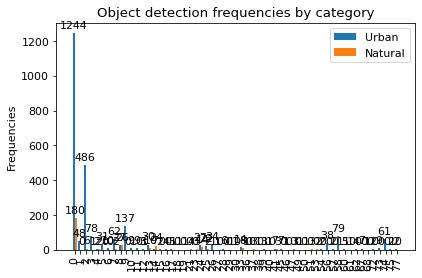

In [23]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random

def sample_images(directory, sample_size=1000):
    all_files = [os.path.join(directory, fname) for fname in os.listdir(directory) if os.path.isfile(os.path.join(directory, fname))]
    sampled_files = random.sample(all_files, min(sample_size, len(all_files)))
    return sampled_files

# Sample a smaller number of images from each directory
sampled_urban_files = sample_images(urban_dir, 1000)
sampled_natural_files = sample_images(natural_dir, 1000)

def analyze_dataset(sampled_files, model):
    object_counts = {}
    # Iterate over all files in the sampled list
    for image_path in sampled_files:
        if not os.path.isfile(image_path):
            print(f"Skipped: {image_path} (Not a file)")
            continue

        # Attempt to process each image file
        try:
            detected_objects = detect_objects(image_path, model)
            if detected_objects.size == 0:
                continue  # Skip this file if no objects were detected (or an error occurred)
            labels = detected_objects[:, -1].int().tolist()  # Extract detected labels
            for label in labels:
                if label in object_counts:
                    object_counts[label] += 1
                else:
                    object_counts[label] = 1
        except Exception as e:
            print(f"Failed to process or skipped image {image_path} due to error: {e}")

    return object_counts

# Analyze the sampled images
urban_objects = analyze_dataset(sampled_urban_files, model)
natural_objects = analyze_dataset(sampled_natural_files, model)

print("Urban objects:", urban_objects)
print("Natural objects:", natural_objects)

def prepare_data_for_plotting(urban_objects, natural_objects):
    # Combine all keys from both dictionaries and initialize counts to zero
    all_objects = set(urban_objects.keys()).union(set(natural_objects.keys()))
    urban_counts = {obj: urban_objects.get(obj, 0) for obj in all_objects}
    natural_counts = {obj: natural_objects.get(obj, 0) for obj in all_objects}

    # Prepare lists for plotting
    labels = list(all_objects)
    urban_values = [urban_counts[label] for label in labels]
    natural_values = [natural_counts[label] for label in labels]

    return labels, urban_values, natural_values

labels, urban_values, natural_values = prepare_data_for_plotting(urban_objects, natural_objects)



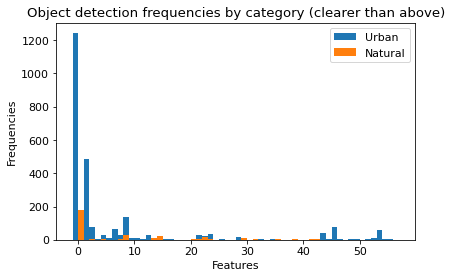

In [89]:
def plot_object_frequencies(labels, urban_values, natural_values):
    x = np.arange(len(labels))  # the label locations
    width = 1  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, urban_values, width, label='Urban')
    rects2 = ax.bar(x + width/2, natural_values, width, label='Natural')

    # Add some text for labels, title, and custom x-axis tick labels, etc.
    ax.set_ylabel('Frequencies')
    ax.set_xlabel('Features')
    ax.set_title('Object detection frequencies by category (clearer than above)')
    ax.legend()

    fig.tight_layout()

    plt.show()

plot_object_frequencies(labels, urban_values, natural_values)

## Analyzing YOLO 

Above is a plot of the frequencies of various objects for the two classes, urban/built and natural. It is curious to see that the frequencies of the highest objects are much higher for the urban class, than the build class. This reflects just what we observed in the sample imagery too, where for the urban class, various objects were detected such as cars and people, but none for the natural class. A hypothesis for this could be that urban structures are oftentimes more stark in their colors and edges, than natural scenery. For example, a red car would pop out in the context of grey buildings, while green trees in a green forest are less easily discernable. These are interesting things to keep in mind as we continue to build up our models. 

# Training Models

In [ ]:
# Environmental Set Up
!pip install torch torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, f1_score
import numpy as np


# Data Augmentation:

Just as with the earlier assignment, we will augment the data to superficially expand it and minimize overfitting. 

In [35]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import os

# Define transformations for the training, validation, and testing data
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Data Splitting

In [37]:
# Path to your dataset directory

data_dir = '/Users/etoileboots/Downloads/dataset/'
print("Loading dataset from:", data_dir)
full_dataset = datasets.ImageFolder(root=data_dir)  # Initially load without transform

# Split the dataset into training, validation, and test sets
train_size = int(0.7 * len(full_dataset))
valid_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - valid_size

# Create subsets for each dataset part, applying the appropriate transform
train_data, valid_data, test_data = random_split(full_dataset, [train_size, valid_size, test_size])

# A helper function to apply transforms to datasets
def apply_transforms(dataset, transform):
    return [(transform(img), label) for img, label in dataset]

# Applying transforms to each subset
train_data = apply_transforms(train_data, train_transform)
valid_data = apply_transforms(valid_data, test_transform)
test_data = apply_transforms(test_data, test_transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


Loading dataset from: /Users/etoileboots/Downloads/dataset/


# Vanilla CNN - ResNet50

We begin with using a pretrained CNN. For this, we will use ResNet50, which uses the concept of residual learning to alleviate the vanishing gradient problem in very deep networks.

**Architecture Overview**

ResNet50 consists of a 50-layer deep network constructed with residual blocks. These blocks use skip connections, or shortcuts, to jump over some layers. Characteristics of ResNet50 include:

- An initial 7x7 convolutional layer with a stride of 2, followed by a max pooling layer, which serves to reduce spatial dimensions while increasing the depth.
- A series of 4 stages, each containing a set of residual blocks. These blocks have a "bottleneck" design to reduce the computational complexity. A bottleneck block consists of three layers: a 1x1 convolution that reduces the dimension, a 3x3 convolution that processes it, and a final 1x1 convolution that restores the dimension.
- The use of batch normalization after every convolution, and before activation, to stabilize and accelerate the training.
- Global average pooling following the residual blocks to reduce feature maps to a single vector per map.
- A fully connected layer that outputs the predictions for the given classes.

**Mathematical Underpinnings**

Each residual block in a ResNet50 can be represented as:

$$y = F(x, W_i) + x$$

Here, $x$ and $y$ are the input and output of the layers considered. $F(x, W_i)$ represents the residual mapping to be learned. For the standard block, it involves two or three layers, depending on whether it is a bottleneck block or not.

- **Identity Shortcut Connection**: If the input and output are of the same dimensions, the shortcut performs identity mapping, and $x$ is added directly to $F(x)$.
- **Projection Shortcut**: When the dimensions increase, the shortcut applies a 1x1 convolution to match the dimensions of $F(x)$ for addition.

**Pseudocode for ResNet50**

```
Initialize weights
For each epoch:
    For each batch in the dataset:
        input -> 7x7 Conv -> BatchNorm -> ReLU -> MaxPool
        input -> Bottleneck layers in 4 stages
        Apply Global Average Pooling
        Classify output using Fully Connected Layer
        Calculate loss and backpropagate
        Update weights
```

**Training and Performance**

The network is trained using stochastic gradient descent or a variant like Adam. The loss function typically used is cross-entropy for classification tasks. ResNet50 is known for its ability to train very deep architectures without performance degradation, thanks to residual blocks.

In [38]:
def train_and_validate(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10, patience=3):
    train_losses = []
    valid_losses = []
    valid_accuracies = []

    # To track the minimum validation loss
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        model.eval()
        valid_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_valid_loss = valid_loss / len(valid_loader)
        valid_losses.append(avg_valid_loss)
        accuracy = correct / total
        valid_accuracies.append(accuracy)

        print(f'Epoch {epoch+1}: Train Loss: {train_losses[-1]:.4f}, Valid Loss: {avg_valid_loss:.4f}, Accuracy: {accuracy:.4f}')

        # Check for early stopping
        if avg_valid_loss < best_val_loss:
            best_val_loss = avg_valid_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # If the validation loss has not improved for 'patience' consecutive epochs, stop the training
        if epochs_no_improve == patience:
            print(f'Early stopping triggered after {epoch+1} epochs!')
            break

    return train_losses, valid_losses, valid_accuracies


In [39]:
from sklearn.metrics import accuracy_score, f1_score

def evaluate(model, loader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    # No gradient is needed for evaluation
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the appropriate device
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Get the predictions
            all_preds.extend(preds.cpu().numpy())  # Save predictions
            all_labels.extend(labels.cpu().numpy())  # Save labels

    # Calculate accuracy and F1 score using ground truth and predictions
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return accuracy, f1


In [40]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, valid_losses, valid_accuracies):
    # Number of epochs is derived from the length of training losses array
    epochs = range(1, len(train_losses) + 1)

    # Setting up the plotting environment with a figure size
    plt.figure(figsize=(12, 4))

    # Plotting the training and validation loss on the first subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')  # Blue dots connected by lines
    plt.plot(epochs, valid_losses, 'ro-', label='Validation Loss')  # Red dots connected by lines
    plt.title('Training and Validation Loss')  # Title of the plot
    plt.xlabel('Epoch')  # X-axis label
    plt.ylabel('Loss')  # Y-axis label
    plt.legend()  # Show legend to identify which line is which

    # Plotting the validation accuracy on the second subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, valid_accuracies, 'go-')  # Green dots connected by lines
    plt.title('Validation Accuracy')  # Title of the plot
    plt.xlabel('Epoch')  # X-axis label
    plt.ylabel('Accuracy')  # Y-axis label
    plt.legend(['Validation Accuracy'])  # Legend for the plot

    # Adjust layout to prevent overlap and show the plot
    plt.tight_layout()
    plt.show()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") ## dhznz
res50model = models.resnet50()
res50model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(res50model.parameters(), lr=0.001)

res50_train_losses, res50_valid_losses, res50_valid_accuracies = train_and_validate(res50model, train_loader, valid_loader, criterion, optimizer, num_epochs=10)


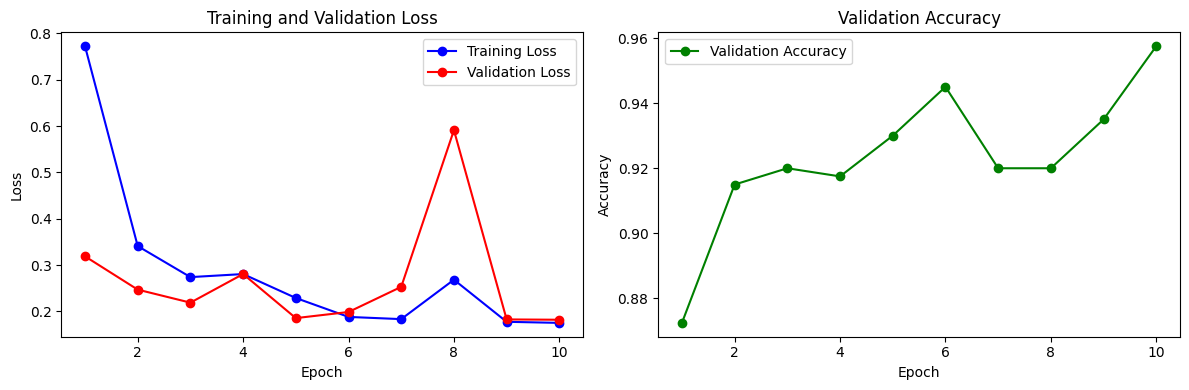

Final Test Accuracy: 0.9700, F1 Score: 0.9700


In [27]:
plot_metrics(res50_train_losses, res50_valid_losses, res50_valid_accuracies)
res50_accuracy, res50_f1 = evaluate(res50model, test_loader)
print(f"Final Test Accuracy: {res50_accuracy:.4f}, F1 Score: {res50_f1:.4f}")


## Analysis of Results

Based on the plots above, we can now better understand how the model has learned from the data over various epochs. Looking to the left, we see the training and validation loss. The training loss begins at a high value, but shows a generally decreasing trend, alongside general decreases in the validation loss. However, not that the validation loss has a spike around the 8th epoch. This can typically be a sign of variability in the validation set, or that the model is starting to overfit the training data arond this epoch.

Now, the validation accuracy starts around 88%, quickly increases, and generally maintains an upward trend, which is positive. There is a slight dip after epoch 6, but the accuracy recovers, reaching its highest point at epoch 10. This indicates that the model is becoming better at generalizing to unseen data.

In general, the final accuracy at epoch 10 is high, suggesting that the model has a strong performance on the validation set.

## Vision Transformers

So far, within CS156, we have only discussed Transformers within the context of natural language processing, so what is it doing here, in this assignment? A relatively new Transformer known as the Vision Transformer (ViT) is an application of Transformer architectures from natural language processing (NLP) to computer vision (CV). The use of transformers in CV is typically to approach the classification problem at a different angle than CNNs. CNNs inherently incorporate biases such as translation invariance and locality, which are beneficial for processing images but may limit flexibility. ViT lacks these biases, making it more general but also more reliant on larger datasets for training. Additionally, unlike CNNs that gradually expand their receptive fields through layers, ViT can attend to global dependencies across the image right from the first layer, potentially capturing complex relationships that CNNs might miss or capture later in their networks.

In the following sections, we will analyze the algorithmic and mathematical underpinnings to this model. 


### Mathematical Foundations of ViT

**Model Architecture:**
ViT applies the Transformer architecture directly to images. An image is divided into patches, which are then flattened and linearly embedded. These embeddings are treated as the input sequence to the Transformer.

The transformer uses self-attention mechanisms to weigh the importance of different patches relative to each other. The attention function can be described mathematically as:

1. **Self-Attention**:
    - The transformer uses self-attention mechanisms to weigh the importance of different patches relative to each other. The attention function can be described mathematically as: 
    $$Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$$
    - **$Q, K, V$** represent queries, keys, and values derived from the input embeddings, respectively.
    - **$d_k$** is the dimensionality of the keys, which scales the dot products to prevent overly large values.

        The output of the attention mechanism is then used to update the input embeddings, which are further processed through MLPs to integrate information across the different representation spaces.

2. **Patch Embedding**:
   - An image $x\in R^{H \times W \times C}$ (where $H, W$ are height and width, and $C$ is the number of channels) is reshaped into a sequence of flattened 2D patches $x_p \in R^{N \times (P^2 \cdot C)}$, where $(P, P)$ is the resolution of each patch, and $N$ is the total number of patches.
   - Each patch is then mapped to a $D$-dimensional embedding space using a trainable linear projection.

3. **Position Embeddings**:
   - To retain positional information, positional embeddings are added to the patch embeddings, similar to the positional encodings in NLP Transformers.

4. **Transformer Encoder**:
   - The sequence of patch embeddings (with position embeddings added) is fed into a standard Transformer encoder.
   - The encoder consists of alternating layers of Multiheaded Self-Attention (MSA) and position-wise Feed-Forward Networks (FFNs), with residual connections and layer normalization.

5. **Classification Head**:
   - A classification token ("[class]") is prepended to the sequence of embeddings, similar to BERT's "[CLS]" token. The state of this token at the output of the Transformer encoder is used to predict the class of the image through a simple MLP head.

**Key Equations**:

- Patch and position embedding: $$z_0 = [x_{class}; x_p^1E; x_p^2E; \ldots; x_p^NE] + E_{pos}$$

- Transformer layers: $$z'_{\ell} = MSA(LN(z_{\ell-1})) + z_{\ell-1}$$ and $$z_{\ell} = MLP(LN(z'_{\ell})) + z'_{\ell}$$

### Pseudocode

```
Initialize patch and position embeddings
For each image:
    Convert image to sequence of patch embeddings
    Add positional embeddings
    For each transformer layer:
        Apply multi-head self-attention
        Apply MLP block
    Aggregate patch representations (e.g., via mean pooling)
    Pass through a final MLP to get class logits
```


In [ ]:
# Load pre-trained ViT
!pip install torch torchvision timm
import timm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ViT_model = timm.create_model('vit_base_patch16_224', pretrained=True)
ViT_model.to(device)


Epoch 1: Train Loss: 1.4057, Valid Loss: 0.6111, Accuracy: 0.6500
Epoch 2: Train Loss: 0.6337, Valid Loss: 0.5013, Accuracy: 0.7550
Epoch 3: Train Loss: 0.5612, Valid Loss: 0.7186, Accuracy: 0.6600
Epoch 4: Train Loss: 0.5464, Valid Loss: 0.4662, Accuracy: 0.7500
Epoch 5: Train Loss: 0.4678, Valid Loss: 0.4356, Accuracy: 0.8000
Epoch 6: Train Loss: 0.4592, Valid Loss: 0.5147, Accuracy: 0.7650
Epoch 7: Train Loss: 0.4405, Valid Loss: 0.4204, Accuracy: 0.7825
Epoch 8: Train Loss: 0.4365, Valid Loss: 0.3839, Accuracy: 0.8225
Epoch 9: Train Loss: 0.4206, Valid Loss: 0.4888, Accuracy: 0.7475
Epoch 10: Train Loss: 0.3764, Valid Loss: 0.4297, Accuracy: 0.8100
Final Test Accuracy: 0.7500, F1 Score: 0.7474


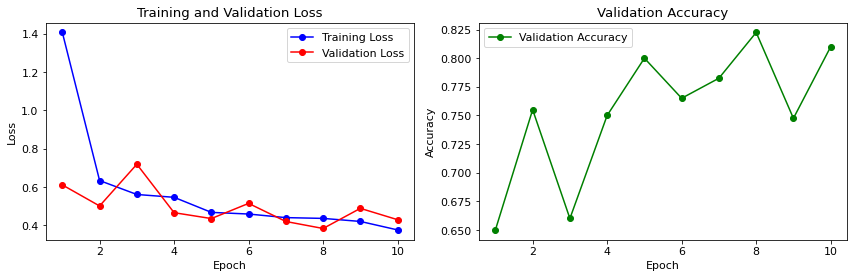

In [53]:
import torch.optim as optim

# Setup criterion
criterion = nn.CrossEntropyLoss()

# Initialize the AdamW optimizer with the Vision Transformer parameters
optimizer = optim.AdamW(ViT_model.parameters(), lr=0.001, weight_decay=0.01)  # Adjust lr and weight_decay as needed

# Training and validation process
ViT_train_losses, ViT_valid_losses, ViT_valid_accuracies = train_and_validate(
    ViT_model, train_loader, valid_loader, criterion, optimizer, num_epochs=10
)

# Plot training metrics
plot_metrics(ViT_train_losses, ViT_valid_losses, ViT_valid_accuracies)

# Evaluate the model
ViT_accuracy, ViT_f1 = evaluate(ViT_model, test_loader)
print(f"Final Test Accuracy: {ViT_accuracy:.4f}, F1 Score: {ViT_f1:.4f}") #bb


## Analysis of Results 

The left graph shows the validation and training loss over epochs. Initially, the training loss starts very high but quickly decreases, indicating that the model is learning from the data. The validation loss generally follows the trend of the training loss, which is good; it means that the model is not overfitting significantly to the training data. There are some fluctuations in the validation loss, which is not uncommon, but the overall trend is downward, which is a positive sign.

The right graph shows larger variance in the validation accuracy over epochs. Generally, there is an upwards trend, but with various spikes. This could be due to several factors, including the learning rate being too high, the batch size being too small, or the model reacting to certain features within the validation set that are not well represented in the training set.

# Previous Models

In [41]:
# import libraries
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline


In [ ]:

# Setup device - use CUDA if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use a pre-trained ResNet50 to extract features
resnet = models.resnet50()
resnet.fc = torch.nn.Identity()  # Modify the fully connected layer to output extracted features
resnet.to(device)
resnet.eval()

In [ ]:
def extract_features(data_loader):
    features = []
    labels = []
    with torch.no_grad():
        for data, target in data_loader:
            # Move data to the appropriate device
            data = data.to(device)
            # Compute the output using the ResNet model
            output = resnet(data)
            # Move output to CPU and convert to numpy for storage/processing
            features.extend(output.cpu().detach().numpy())
            # Ensure labels are on CPU before converting to numpy
            labels.extend(target.cpu().numpy())

    return features, labels

# Try to extract features from the train and test loaders
try:
    train_features, train_labels = extract_features(train_loader)
    test_features, test_labels = extract_features(test_loader)
except Exception as e:
    print(f"An error occurred: {e}")


In [44]:
# Define classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVC": SVC(),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "XGBoost": XGBClassifier()
}

# Train and evaluate classifiers
results = {}
for name, clf in classifiers.items():
    pipeline = make_pipeline(StandardScaler(), PCA(n_components=100), clf)
    pipeline.fit(train_features, train_labels)
    predictions = pipeline.predict(test_features)
    accuracy = accuracy_score(test_labels, predictions)
    results[name] = accuracy

# Print results
for name, accuracy in results.items():
    print(f"{name}: Accuracy = {accuracy:.2f}")


/Users/etoileboots/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Logistic Regression: Accuracy = 0.77
SVC: Accuracy = 0.81
KNN: Accuracy = 0.68
Naive Bayes: Accuracy = 0.54
Random Forest: Accuracy = 0.76
XGBoost: Accuracy = 0.80


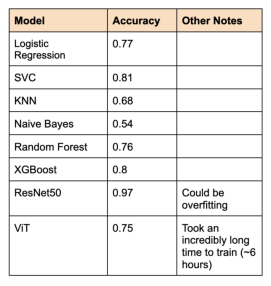

In [92]:
# Load the image
img = Image.open("/Users/etoileboots/Downloads/summary_table.png")

# Create a figure with a specific size
fig = plt.figure(figsize=(5, 5)) 

# Display the image
plt.imshow(img)

# Remove axes and show the figure
plt.axis('off')
plt.show()


# Conclusions 

So throughout this model exploration, what did we discover? 

We tried out CNNs and transformers, and can analyze the best fitting model as both the most efficient, and accurate out of the tested models. Clearly, ViTs are not the appropriate choice in this simple classification task, as the computational time, and unrewarding results in terms of accuracy prevent us from choosing to use this model in the future. The pretrained CNN with ResNet50 clearly performs the best, so much so that it may be overfitting with as accuracy of 0.97. Regardless, for more complicated tasks, this model is probably our best bet. 

# Possible Next Extensions - Capsule Neural Network

One particular model I was excited to employ, but unable to get to work correctly was the Capsule Networks. The particular features of such CapsNet make it an appropriate additional experimental step. 

Capsule Networks (Hinton et al., 2017) develop on the traditional CNN, addressing the loss in spatial hierarchies between features due to pooling layers, which CapsNets tackle with capsules capable of encoding spatial relationships and instance parameters. This capability allows CapsNets to maintain detailed information about object composition and orientation, which is often lost in traditional CNNs due to pooling operations.

**Key Components of Capsule Networks**

*Capsules:*  A capsule is essentially a collection of neurons, but unlike a typical neuron in CNNs, each capsule outputs a vector instead of a scalar. This vector represents various properties of a particular type of entity (like an object or a part of an object) within the image. The orientation of the vector encodes the properties of the entity (such as pose, deformation, and texture), and the length of the vector indicates the probability that the entity exists in the current input.

*Dynamic Routing:* Unlike CNNs that use pooling layers to reduce dimensionality, CapsNets use a "routing-by-agreement" mechanism. High-level capsules receive more input from lower-level capsules that have a high agreement on the output. This dynamic routing between capsules allows the network to learn spatial hierarchies between features.

*Squashing Function:* This non-linear function ensures that the length of the output vector of a capsule is between 0 and 1, enabling it to be used as a probability. The function is defined as follows:
$$v_j = \frac{{\|s_j\|^2}}{{1 + \|s_j\|^2}} \frac{{s_j}}{{\|s_j\|}}$$
where $v_j$ is the vector output of capsule $j$ and $s_j$ is its total input.

**Structure of CapsNet**

CapsNet architectures generally consist of several layers:

1. *Convolutional Layer:* This initial layer detects basic features from input images, similar to traditional CNNs.
2. *Primary Capsules Layer:* This layer transforms the scalar output of the convolutional layer into vector outputs in the form of capsules.
3. *Digit Capsules Layer:* The final layer uses the dynamic routing mechanism to allow capsules to learn to recognize more complex entities by combining information from lower-level capsules.

### Pseudocode for a CapsNet

```
Initialize CapsNet with Convolutional and Capsule layers
For each epoch:
    For each batch:
        Perform a forward pass:
            1. Convolutional Layer extracts basic features.
            2. Primary Capsules convert these features into initial capsule vectors.
            3. Digit Capsules use dynamic routing to build higher-level representations.
        Calculate the loss (e.g., Margin Loss for each capsule).
        Backpropagate the errors.
        Update weights.
Evaluate the model on the test set.
```

**Mathematical Underpinnings**

The core operation within CapsNets involves the routing mechanism. Here, the input to a capsule is a weighted sum over all "prediction vectors" from the capsules in the layer below:
$$s_j = \sum_{i} c_{ij} \hat{u}_{j|i}$$
where $4c_{ij}$ are coupling coefficients determined by the iterative dynamic routing process, and $\hat{u}_{j|i}$ is a prediction vector from capsule $i$ to capsule $j$, computed by multiplying the output $u_i$ of capsule $i$ by a weight matrix $W_{ij}$:
$$
\hat{u}_{j|i} = W_{ij}u_i
$$

**Training and Loss:**
CapsNets often use a margin loss for each capsule to ensure the network learns to recognize the presence and absence of entities correctly. This loss encourages the correct capsule to have a long output vector (if the entity is present) and others to have short vectors.


# Citations

Alammar, J. (2020). The illustrated transformer. https://jalammar.github.io/illustrated-transformer/


Cityscapes Dataset – Semantic Understanding of Urban street Scenes. (2020, October 17). https://www.cityscapes-dataset.com/


Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., Dehghani, M., Minderer, M., Heigold, G., Gelly, S., Uszkoreit, J., & Houlsby, N. (2020, October 22). An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale. arXiv.org. https://arxiv.org/abs/2010.11929


Hinton, G. E., Sabour, S., & Frosst, N. (2017). Dynamic Routing Between Capsules. NIPS.


Marco Tulio Ribeiro, Sameer Singh, and Carlos Guestrin. 2016. Why should i
trust you?: Explaining the predictions of any classifier. In Proceedings of the 22nd
ACM SIGKDD International Conference on Knowledge Discovery and Data Mining.
ACM, 1135–1144


NielsRogge. (2023). Transformers-Tutorials/VisionTransformer/Quick_demo_of_HuggingFace_version_of_Vision_Transformer_inference.ipynb at master · NielsRogge/Transformers-Tutorials. GitHub. https://github.com/NielsRogge/Transformers-Tutorials/blob/master/VisionTransformer/Quick_demo_of_HuggingFace_version_of_Vision_Transformer_inference.ipynb

ResNet-50: the basics and a quick tutorial. (2023, May 22). Datagen. https://datagen.tech/guides/computer-vision/resnet-50/#:~:text=ResNet%2D50%20is%20a%2050,networks%20by%20stacking%20residual%20blocks.

Van Der Linden, I., University of Amsterdam, Haned, H., University of Amsterdam, Ahold Delhaize, Kanoulas, E., & University of Amsterdam. (2019). Global Aggregations of Local Explanations for Black Box models. In SIGIR ’19: The 42nd International ACM SIGIR Conference on Research & Development in Information Retrieval (p. 8). https://arxiv.org/pdf/1907.03039.pdf#page=8&zoom=100,424,220


---



# AI Statement

In this assignment, I used ChatGPT as a code assistant and to provide various resources and syntheses of readings. 